In [1]:
import pandas as pd

# Cargar los archivos con el separador adecuado (tabulación)
entities_df = pd.read_csv('entities_train.csv', sep='\t')
relations_df = pd.read_csv('relations_train.csv', sep='\t')
abstracts_df = pd.read_csv('abstracts_train.csv', sep='\t')
# Asegurarse de que todos los identificadores de 'abstract_id' sean strings
entities_df['abstract_id'] = entities_df['abstract_id'].astype(str)
abstracts_df['abstract_id'] = abstracts_df['abstract_id'].astype(str)
relations_df['abstract_id'] = relations_df['abstract_id'].astype(str)

# Unir los resúmenes con las relaciones usando 'abstract_id'
merged_df = pd.merge(relations_df, abstracts_df[['abstract_id', 'abstract', 'title']], on='abstract_id', how='inner')

# Unir la información de las entidades, primero para 'entity_1' y luego para 'entity_2'
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_1_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 1
merged_df.rename(columns={'mention': 'entity_1_mention', 'type': 'entity_1_type'}, inplace=True)

# Unir nuevamente con las entidades para obtener la entidad 2
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_2_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 2
merged_df.rename(columns={'mention': 'entity_2_mention', 'type': 'entity_2_type'}, inplace=True)
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Asumiendo que merged_df ya está creado y contiene las columnas 'abstract' y 'type_x' (que es la relación)

# 1. Convertir los abstracts a minúsculas
merged_df['abstract'] = merged_df['abstract'].str.lower()

# Verificar que se haya hecho la conversión a minúsculas
print("Abstracts en minúsculas:\n", merged_df['abstract'].head())

# 1. Formatear los textos de entrada para incluir las entidades
merged_df['formatted_text'] = (
    "[ENTITY_1] " + merged_df['entity_1_mention'] +
    " [ENTITY_2] " + merged_df['entity_2_mention'] +
    " Abstract: " + merged_df['abstract']
)

# 2. Convertir los textos formateados a minúsculas
merged_df['formatted_text'] = merged_df['formatted_text'].str.lower()

# 3. Tokenización y Padding
# Parámetros
max_words = 10000  # Número máximo de palabras
max_len = 100  # Longitud máxima de las secuencias

# Crear el tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(merged_df['formatted_text'])

# Convertir los textos formateados a secuencias
sequences = tokenizer.texts_to_sequences(merged_df['formatted_text'])

# Aplicar padding
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# 4. Etiquetado de las relaciones
label_encoder = LabelEncoder()
merged_df['relation_label'] = label_encoder.fit_transform(merged_df['type_x'])

# Verificación
print("Primeros textos formateados:\n", merged_df['formatted_text'].head())
print("Primeras secuencias tokenizadas y con padding:\n", padded_sequences[:5])
print("Etiquetas de relación:\n", merged_df['relation_label'].head())
print("Tamaño de las secuencias con padding:", padded_sequences.shape)
print("Tamaño de las etiquetas:", merged_df['relation_label'].shape)

Abstracts en minúsculas:
 0    we report on a new allele at the arylsulfatase...
1    we report on a new allele at the arylsulfatase...
2    we report on a new allele at the arylsulfatase...
3    we report on a new allele at the arylsulfatase...
4    we report on a new allele at the arylsulfatase...
Name: abstract, dtype: object
Primeros textos formateados:
 0    [entity_1] arylsulfatase a [entity_2] metachro...
1    [entity_1] arylsulfatase a [entity_2] metachro...
2    [entity_1] arylsulfatase a [entity_2] mld abst...
3    [entity_1] arylsulfatase a [entity_2] mld abst...
4    [entity_1] arylsulfatase a [entity_2] mld abst...
Name: formatted_text, dtype: object
Primeras secuencias tokenizadas y con padding:
 [[9078   25   23  426   26    7  382  131   51    2 7907    7 6663  796
  1296 4906  483 9077 9078 6603    5   14  131 8219    7 1469   14   17
   700 2725    5    2 7907   31  186   17 5942   16 1526    5  496    8
   799   14  466  774  483 6603    2 8219    8 1526  296   17   

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D

# Parámetros del modelo
embedding_dim = 100  # Dimensión del embedding
vocab_size = 10000   # Tamaño del vocabulario (debe coincidir con el tokenizador)
max_len = 100        # Longitud máxima de las secuencias (debe coincidir con el padding)

# Crear el modelo
model = Sequential([
    # Capa de embeddings
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),

    # Capa recurrente bidireccional LSTM
    Bidirectional(LSTM(64, return_sequences=True)),

    # Capa de pooling global
    GlobalMaxPooling1D(),

    # Capa densa con Dropout
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Capa de salida
    Dense(len(label_encoder.classes_), activation='softmax')  # El número de clases coincide con las etiquetas
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Pérdida para clasificación multiclase
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

# Entrenamiento del modelo
# Asume que `padded_sequences` es la entrada y `merged_df['relation_label']` es la salida
history = model.fit(
    padded_sequences,
    merged_df['relation_label'],
    epochs=10,              # Número de épocas ajustable
    batch_size=32,          # Tamaño del batch
    validation_split=0.2,   # Validación en 20% de los datos
    verbose=1
)
model.save('LTSM_2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 276s 147ms/step - accuracy: 0.5879 - loss: 0.9911 - val_accuracy: 0.6134 - val_loss: 1.0388
Epoch 2/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 320s 146ms/step - accuracy: 0.6657 - loss: 0.7436 - val_accuracy: 0.6056 - val_loss: 1.0447
Epoch 3/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 271s 147ms/step - accuracy: 0.6663 - loss: 0.7280 - val_accuracy: 0.5001 - val_loss: 1.1306
Epoch 4/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 323s 147ms/step - accuracy: 0.6690 - loss: 0.7216 - val_accuracy: 0.5271 - val_loss: 1.1416
Epoch 5/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 271s 146ms/step - accuracy: 0.6692 - loss: 0.7185 - val_accuracy: 0.5833 - val_loss: 1.1707
Epoch 6/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 270s 146ms/step - accuracy: 0.6682 - loss: 0.7156 - val_accuracy: 0.5833 - val_loss: 1.1944
Epoch 7/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 323s 147ms/step - accuracy: 0.6718 - loss: 0.7110 - val_accuracy: 0.5254 - val_loss: 1.1871
Epoch 8/10
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 322s 147ms/step - ac

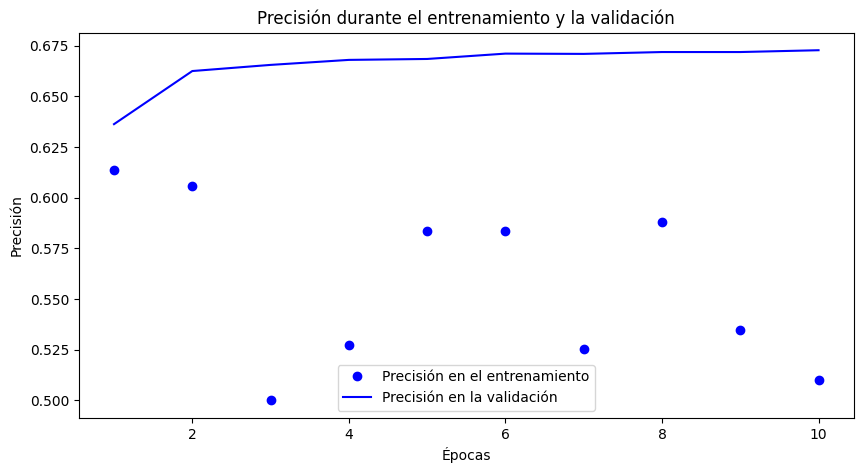

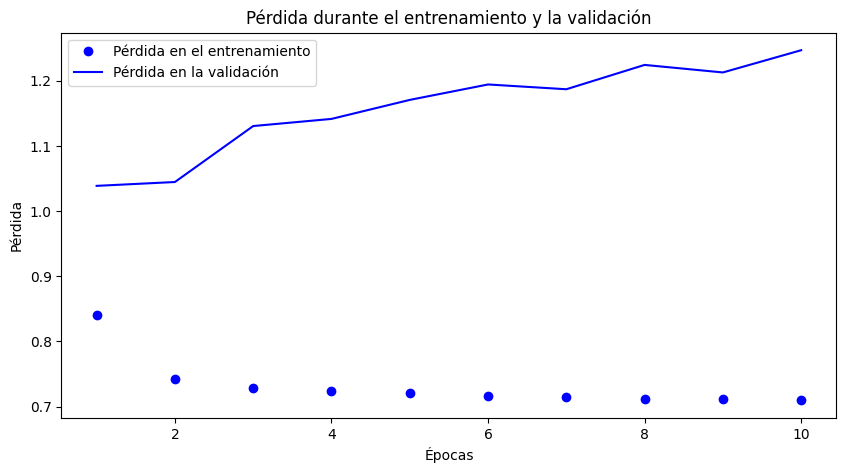

In [ ]:
import matplotlib.pyplot as plt

# Extraer los datos de precisión y pérdida del historial de entrenamiento
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# Graficar la precisión
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, 'bo', label='Precisión en el entrenamiento')
plt.plot(epochs,accuracy, 'b', label='Precisión en la validación')
plt.title('Precisión durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida en la validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Parámetros del modelo
vocab_size = 10000  # Tamaño del vocabulario (debe coincidir con el tokenizer)
embedding_dim = 128  # Dimensión del embedding
max_len = 100  # Longitud máxima de las secuencias (debe coincidir con el padding)
dropout_rate = 0.5  # Tasa de Dropout
num_classes = len(label_encoder.classes_)  # Número de clases (relaciones)
learning_rate = 1e-4  # Tasa de aprendizaje

# Construir el modelo secuencial
model_rnn = Sequential()

# 1. Capa de Embedding
model_rnn.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))

# 2. Capa Bidirectional RNN
model_rnn.add(Bidirectional(SimpleRNN(128, return_sequences=True)))  # RNN bidireccional

# 3. Segunda capa RNN
model_rnn.add(SimpleRNN(64, return_sequences=False))  # Segunda capa RNN

# 4. Capa de Dropout
model_rnn.add(Dropout(dropout_rate))

# 5. Capa densa con regularización L2
model_rnn.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))

# Compilar el modelo
optimizer = Adam(learning_rate=learning_rate)
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Resumen del modelo
model_rnn.summary()

# Entrenar el modelo
# Usa `padded_sequences` como entrada y `merged_df['relation_label']` como etiquetas
history_rnn = model_rnn.fit(
    padded_sequences,  # Secuencias tokenizadas y con padding
    merged_df['relation_label'],  # Etiquetas actualizadas
    epochs=20,  # Ajusta según tu capacidad computacional
    batch_size=32,  # Tamaño del batch
    validation_split=0.2,  # Validación en 20% de los datos
    verbose=1
)
model_rnn.save('modelo_rnn_entrenado.h5')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 276s 147ms/step - accuracy: 0.5680 - loss: 1.2492 - val_accuracy: 0.4454 - val_loss: 1.3188
Epoch 2/20
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 323s 147ms/step - accuracy: 0.6523 - loss: 0.9005 - val_accuracy: 0.4470 - val_loss: 1.2754
Epoch 3/20
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 323s 148ms/step - accuracy: 0.6506 - loss: 0.8535 - val_accuracy: 0.4269 - val_loss: 1.2790
Epoch 4/20
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 321s 147ms/step - accuracy: 0.6589 - loss: 0.8309 - val_accuracy: 0.4574 - val_loss: 1.2381
Epoch 5/20
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 323s 148ms/step - accuracy: 0.6597 - loss: 0.8190 - val_accuracy: 0.3975 - val_loss: 1.2743
Epoch 6/20
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 321s 148ms/step - accuracy: 0.6604 - loss: 0.8076 - val_accuracy: 0.4534 - val_loss: 1.2053
Epoch 7/20
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 280s 151ms/step - accuracy: 0.6617 - loss: 0.8011 - val_accuracy: 0.4501 - val_loss: 1.2385
Epoch 8/20
1848/1848 ━━━━━━━━━━━━━━━━━━━━ 272s 147ms/step - ac

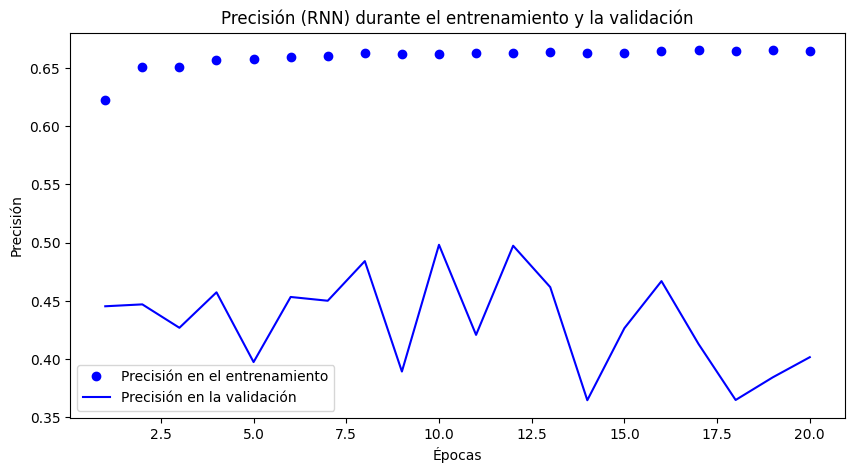

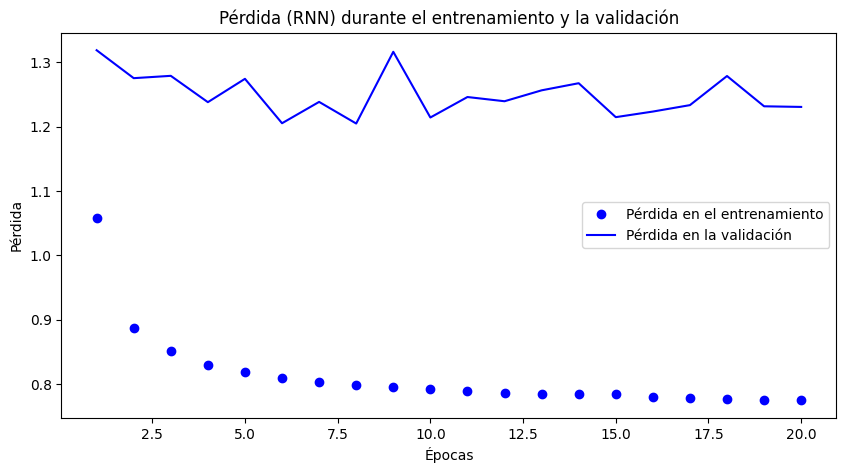

In [ ]:
import matplotlib.pyplot as plt

# Extraer los datos de precisión y pérdida del historial de entrenamiento del RNN
history_dict_rnn = history_rnn.history
accuracy_rnn = history_dict_rnn['accuracy']
val_accuracy_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs = range(1, len(accuracy_rnn) + 1)

# Graficar la precisión (RNN)
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy_rnn, 'bo', label='Precisión en el entrenamiento')
plt.plot(epochs, val_accuracy_rnn, 'b', label='Precisión en la validación')
plt.title('Precisión (RNN) durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida (RNN)
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_rnn, 'bo', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss_rnn, 'b', label='Pérdida en la validación')
plt.title('Pérdida (RNN) durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [ ]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Attention, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Concatenate


# Paso 1: Preprocesamiento
# Usando el DataFrame `merged_df` con tus datos preprocesados

# Añadir delimitadores para las entidades en el texto del abstract
merged_df['input_text'] = merged_df.apply(
    lambda row: f"[ENTITY_1] {row['entity_1_mention']} [ENTITY_2] {row['entity_2_mention']} Context: {row['abstract']}",
    axis=1
)

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
merged_df['relation_label'] = label_encoder.fit_transform(merged_df['type_x'])

# Dividir en conjunto de entrenamiento y prueba
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Tokenización y padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['input_text'])
X_train = tokenizer.texts_to_sequences(train_df['input_text'])
X_test = tokenizer.texts_to_sequences(test_df['input_text'])

# Padding de secuencias
max_len = 150
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Obtener las etiquetas
y_train = train_df['relation_label'].values
y_test = test_df['relation_label'].values

# Paso 2: Implementar el modelo Attention-Based CNN

# Definir el input layer
input_layer = Input(shape=(max_len,))

# Capa de embedding
embedding_dim = 128
embedding_layer = Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_len)(input_layer)

# Capa convolucional para capturar patrones locales
conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = GlobalMaxPooling1D()(conv_layer)

# Capa de atención
attention_layer = Attention()([embedding_layer, embedding_layer])

# Fusionar salida de atención y pooling
flatten_attention = Flatten()(attention_layer)
combined_features = Concatenate()([pooling_layer, flatten_attention])

# Capa densa con dropout
dropout_rate = 0.5
dense_layer = Dense(64, activation='relu')(combined_features)
dropout_layer = Dropout(dropout_rate)(dense_layer)

# Capa de salida con softmax para clasificación multiclase
num_classes = len(label_encoder.classes_)
output_layer = Dense(num_classes, activation='softmax')(dropout_layer)

# Definir el modelo
model = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ver el resumen del modelo
model.summary()

# Paso 3: Entrenar el modelo
history = model.fit(
    X_train,
    y_train,
    epochs=20,  # Ajusta según tus recursos
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Paso 4: Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Paso 5: Reporte de clasificación
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 150)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 150, 128)       │      1,280,000 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 146, 128)       │         82,048 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 150, 128)       │              0 │ embedding_5[0][0],     │
│                           │                        │                │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 128)            │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 19200)          │              0 │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 19328)          │              0 │ global_max_pooling1d_… │
│                           │                        │                │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │      1,237,056 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8)              │            520 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,599,624 (9.92 MB)

 Trainable params: 2,599,624 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 216s 144ms/step - accuracy: 0.6128 - loss: 0.9397 - val_accuracy: 0.6697 - val_loss: 0.7492
Epoch 2/20
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 264s 146ms/step - accuracy: 0.6553 - loss: 0.7666 - val_accuracy: 0.6751 - val_loss: 0.7192
Epoch 3/20
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 227s 153ms/step - accuracy: 0.6590 - loss: 0.7489 - val_accuracy: 0.6739 - val_loss: 0.7193
Epoch 4/20
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 248s 144ms/step - accuracy: 0.6584 - loss: 0.7472 - val_accuracy: 0.6662 - val_loss: 0.7171
Epoch 5/20
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 265s 145ms/step - accuracy: 0.6570 - loss: 0.7375 - val_accuracy: 0.6732 - val_loss: 0.7286
Epoch 6/20
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 262s 146ms/step - accuracy: 0.6575 - loss: 0.7451 - val_accuracy: 0.6684 - val_loss: 0.7190
Epoch 7/20
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 216s 146ms/step - accuracy: 0.6614 - loss: 0.7392 - val_accuracy: 0.6797 - val_loss: 0.7096
Epoch 8/20
1479/1479 ━━━━━━━━━━━━━━━━━━━━ 216s 146ms/step - ac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


462/462 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Attention-Based CNN Accuracy: 0.68
LSTM Accuracy: 0.47
RNN Accuracy: 0.48


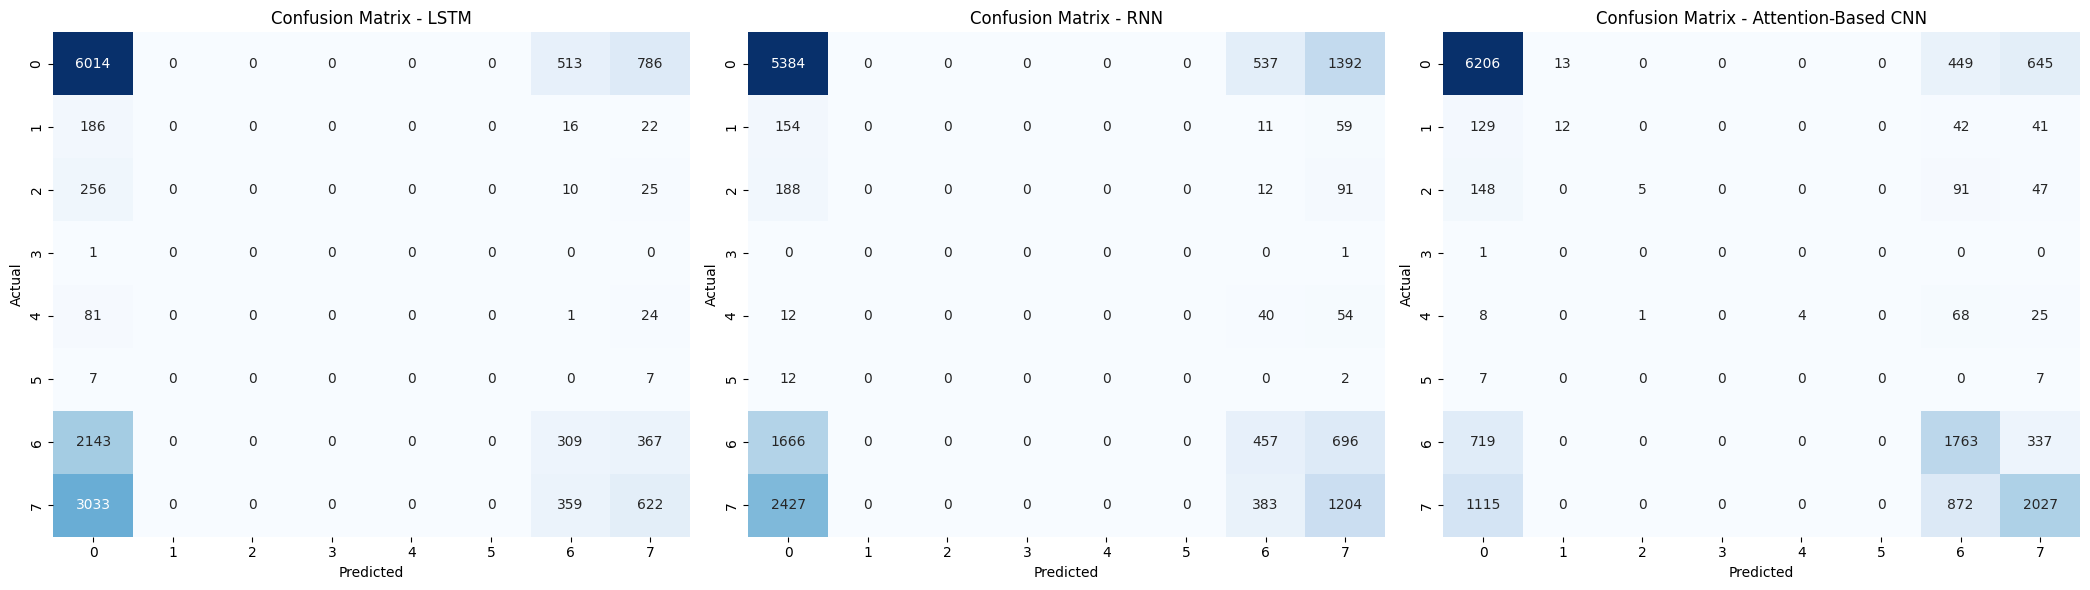

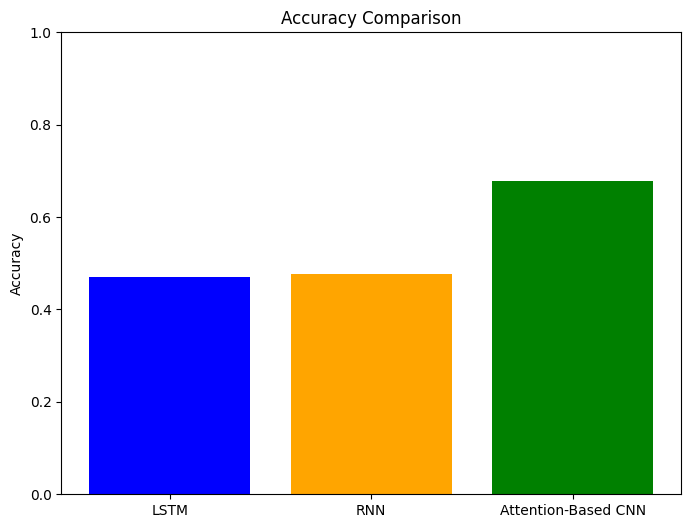

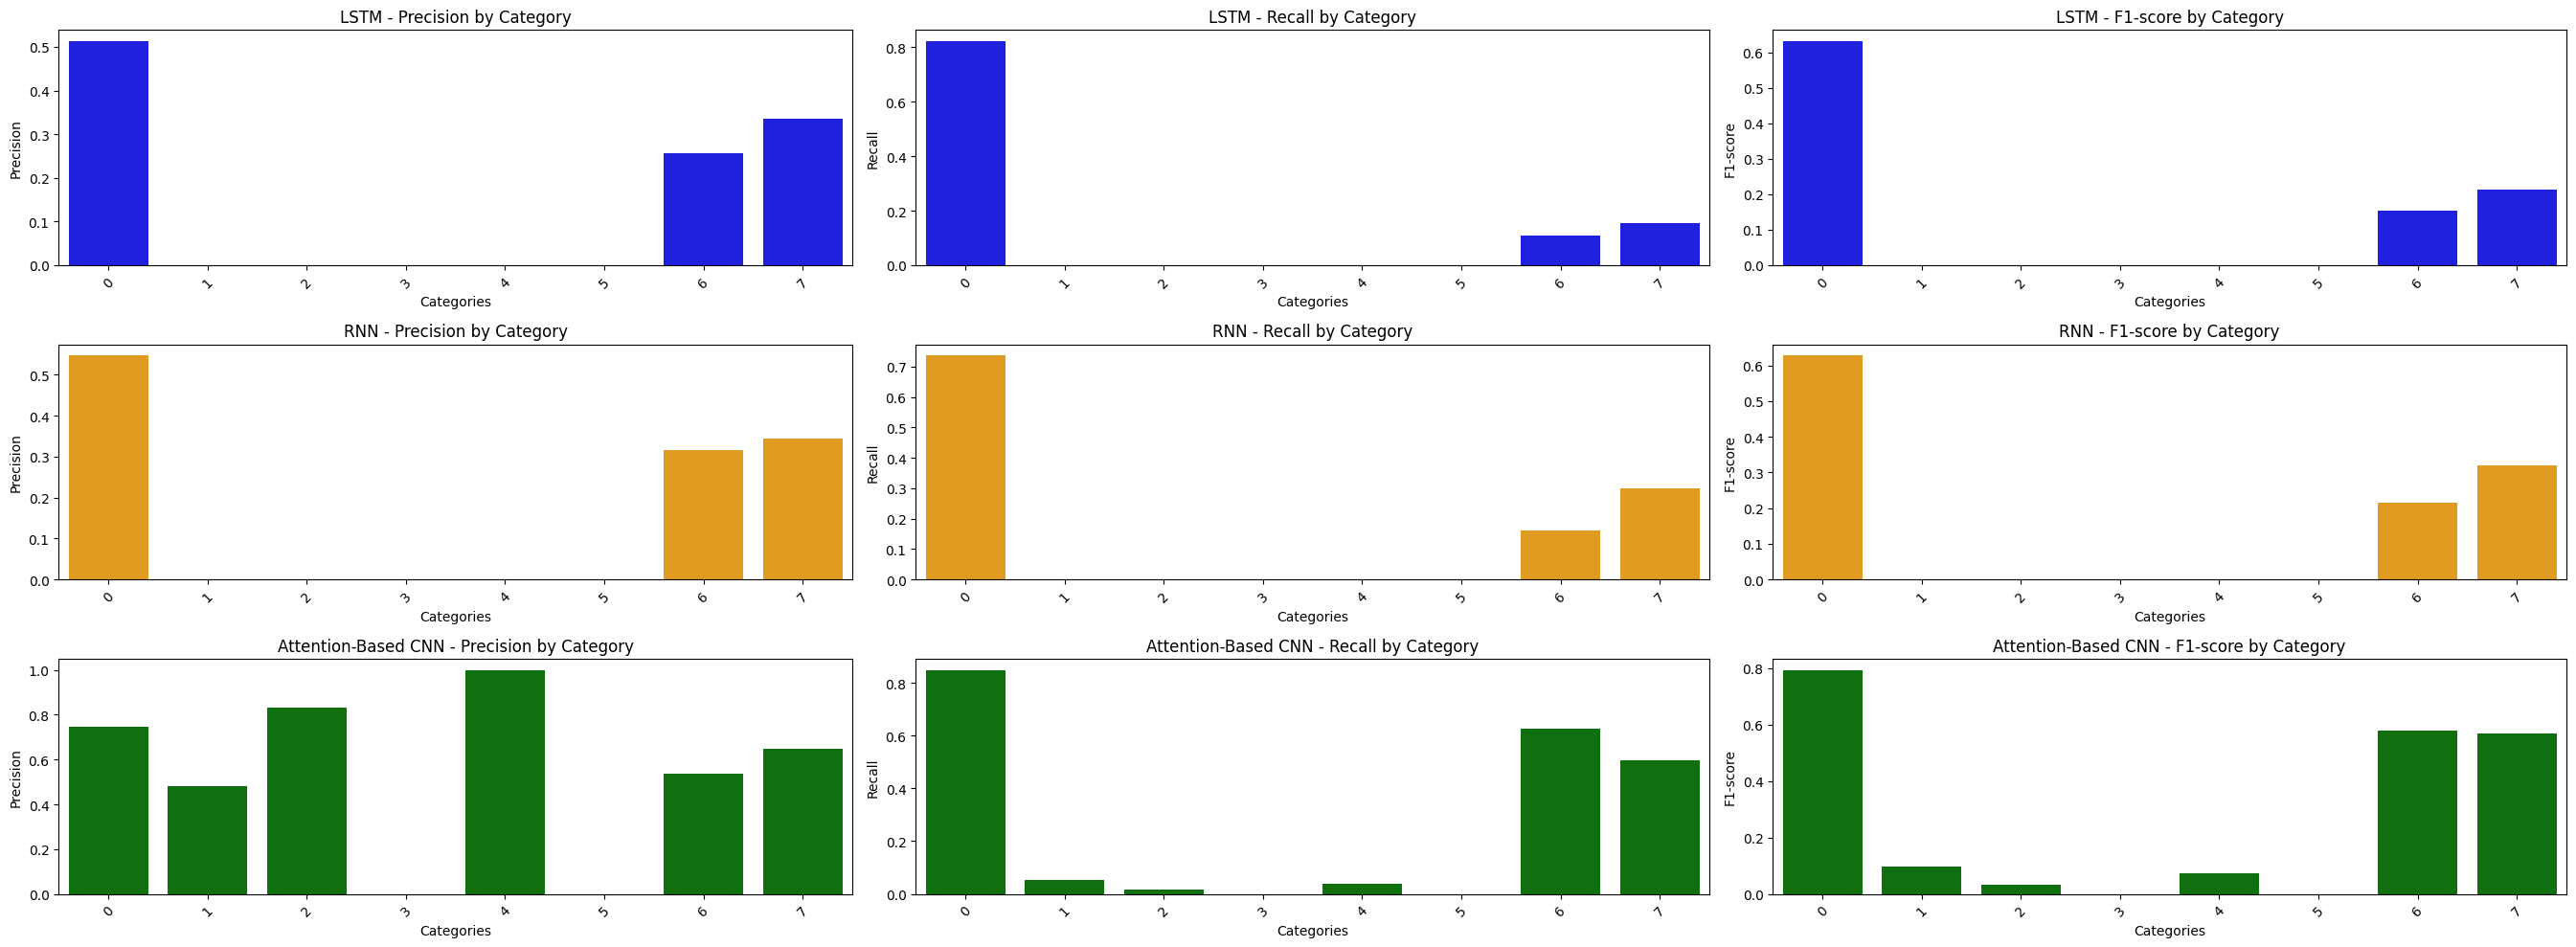

In [ ]:
# Importar bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

# Cargar el modelo desde un archivo .h5
ltsn = load_model('/content/LTSM_2.h5')

# Asegurar que `X_test` tenga el padding correcto
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

# Generar predicciones para cada modelo
y_pred_cnn = np.argmax(model.predict(X_test), axis=-1)  # Attention-Based CNN
y_pred_lstm = ltsn.predict(X_test).argmax(axis=1)  # LSTM
y_pred_rnn = model_rnn.predict(X_test).argmax(axis=1)  # RNN

# Función para calcular métricas
def calculate_metrics(y_true, y_pred, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    metrics_df = pd.DataFrame(report).transpose()
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    return conf_matrix, metrics_df, accuracy

# Calcular métricas para cada modelo
conf_matrix_cnn, category_metrics_cnn, accuracy_cnn = calculate_metrics(y_test, y_pred_cnn, "Attention-Based CNN")
conf_matrix_lstm, category_metrics_lstm, accuracy_lstm = calculate_metrics(y_test, y_pred_lstm, "LSTM")
conf_matrix_rnn, category_metrics_rnn, accuracy_rnn = calculate_metrics(y_test, y_pred_rnn, "RNN")

# Visualización de matrices de confusión
plt.figure(figsize=(21, 6))

# Matriz de confusión LSTM
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - LSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Matriz de confusión RNN
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_rnn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - RNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Matriz de confusión Attention-Based CNN
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Attention-Based CNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

# Visualización de comparación de precisión
models = ['LSTM', 'RNN', 'Attention-Based CNN']
accuracies = [accuracy_lstm, accuracy_rnn, accuracy_cnn]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Visualización de métricas por categoría: precisión, recall y F1-score
metrics = ['precision', 'recall', 'f1-score']
categories = category_metrics_lstm.index[:-3]  # Excluir 'accuracy', 'macro avg', 'weighted avg'

plt.figure(figsize=(27, 10))

# LSTM métricas por categoría
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 1)
    sns.barplot(x=categories, y=category_metrics_lstm[metric][:-3], color='blue')
    plt.title(f'LSTM - {metric.capitalize()} by Category')
    plt.xticks(rotation=45)
    plt.ylabel(metric.capitalize())
    plt.xlabel("Categories")

# RNN métricas por categoría
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 4)
    sns.barplot(x=categories, y=category_metrics_rnn[metric][:-3], color='orange')
    plt.title(f'RNN - {metric.capitalize()} by Category')
    plt.xticks(rotation=45)
    plt.ylabel(metric.capitalize())
    plt.xlabel("Categories")

# Attention-Based CNN métricas por categoría
for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i + 7)
    sns.barplot(x=categories, y=category_metrics_cnn[metric][:-3], color='green')
    plt.title(f'Attention-Based CNN - {metric.capitalize()} by Category')
    plt.xticks(rotation=45)
    plt.ylabel(metric.capitalize())
    plt.xlabel("Categories")

plt.tight_layout()
plt.show()


462/462 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step


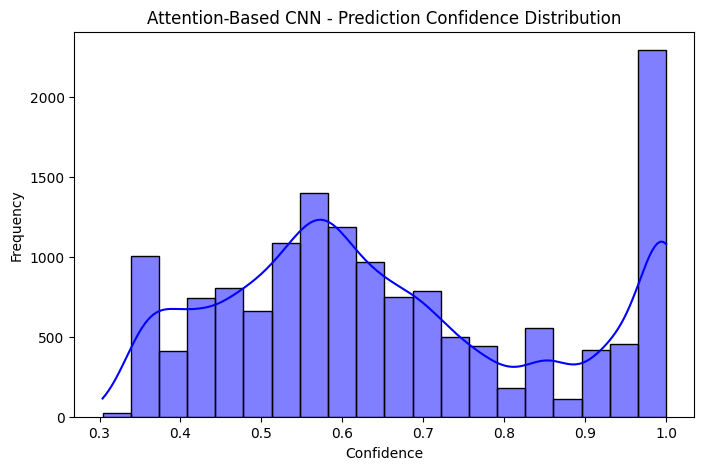

462/462 ━━━━━━━━━━━━━━━━━━━━ 31s 67ms/step


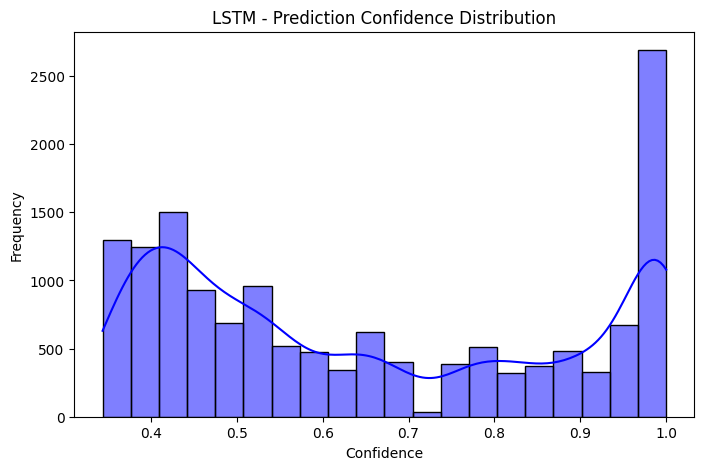

462/462 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step


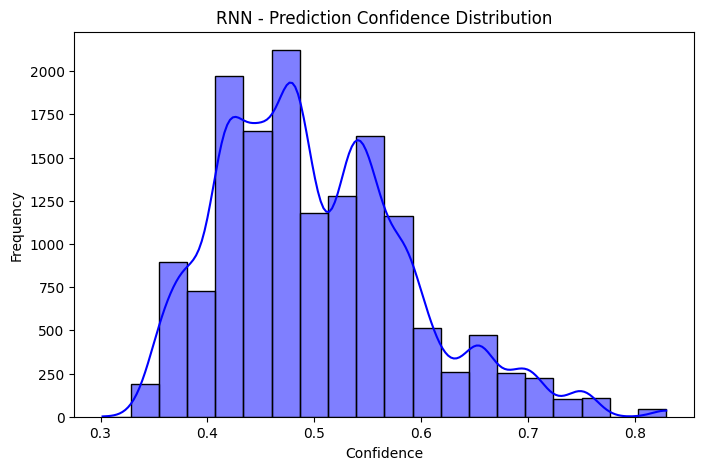

In [ ]:
def plot_prediction_confidence(y_pred, model_name):
    confidence = y_pred.max(axis=1)  # Máxima probabilidad de cada predicción
    plt.figure(figsize=(8, 5))
    sns.histplot(confidence, kde=True, bins=20, color='blue')
    plt.title(f'{model_name} - Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.show()

# Llama a la función para cada modelo
plot_prediction_confidence(model.predict(X_test), "Attention-Based CNN")
plot_prediction_confidence(model_lstm.predict(X_test), "LSTM")
plot_prediction_confidence(model_rnn.predict(X_test), "RNN")


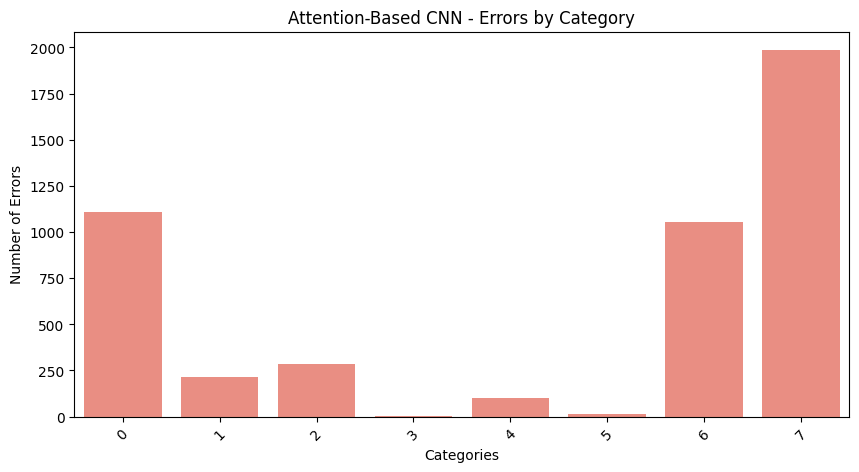

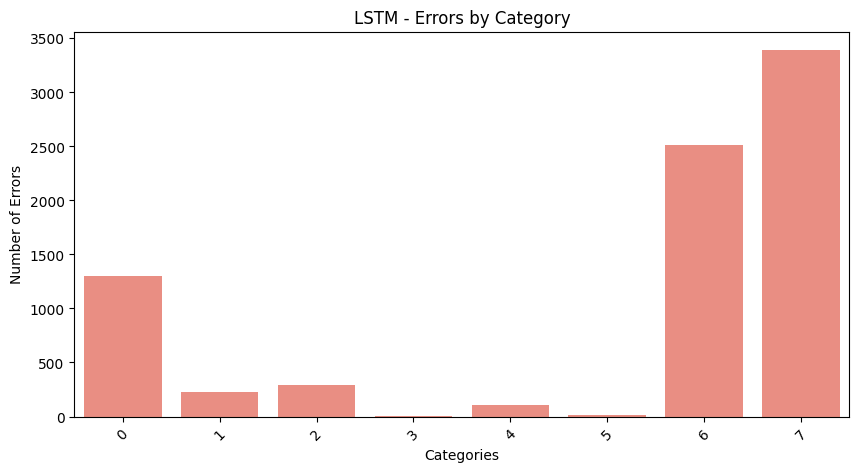

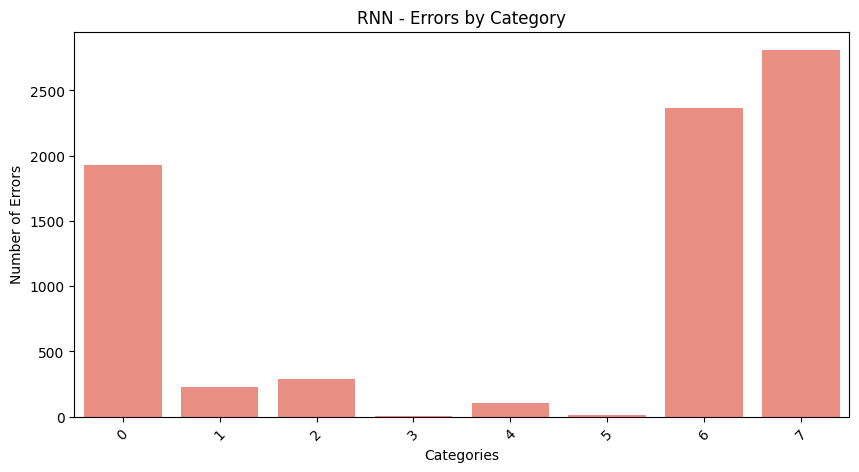

In [ ]:
def plot_errors_by_category(y_true, y_pred, categories, model_name):
    conf_matrix = confusion_matrix(y_true, y_pred)
    errors = conf_matrix.sum(axis=1) - np.diag(conf_matrix)  # Errores por categoría

    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=errors, color='salmon')
    plt.title(f'{model_name} - Errors by Category')
    plt.xlabel("Categories")
    plt.ylabel("Number of Errors")
    plt.xticks(rotation=45)
    plt.show()

# Llama a la función para cada modelo
categories = category_metrics_cnn.index[:-3]  # Excluir promedios
plot_errors_by_category(y_test, y_pred_cnn, categories, "Attention-Based CNN")
plot_errors_by_category(y_test, y_pred_lstm, categories, "LSTM")
plot_errors_by_category(y_test, y_pred_rnn, categories, "RNN")


In [ ]:
from sklearn.inspection import permutation_importance

def plot_feature_importance(model, X_test, y_test, model_name):
    # Calcula la importancia de las características mediante permutación
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')
    importance = result.importances_mean

    # Graficar
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(importance)), importance, color='teal')
    plt.title(f'{model_name} - Feature Importance')
    plt.xlabel('Feature Index')
    plt.ylabel('Importance Score')
    plt.show()

# Llama a la función para un modelo (puede ser CNN, LSTM o RNN)
plot_feature_importance(model, X_test, y_test, "Attention-Based CNN")


462/462 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

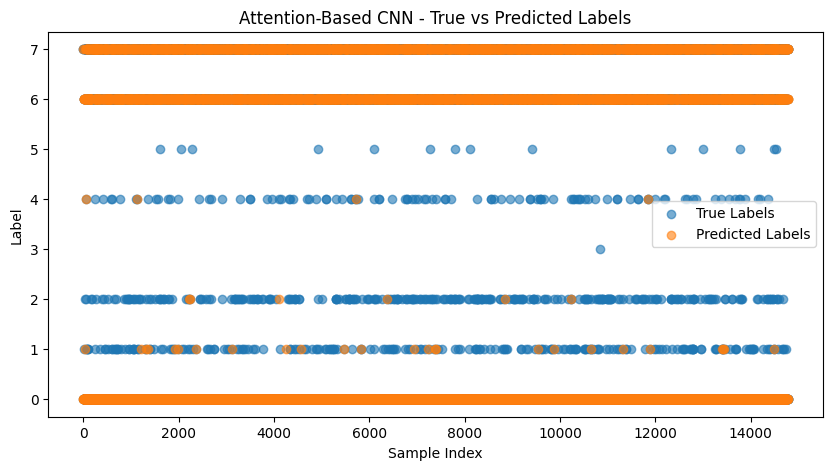

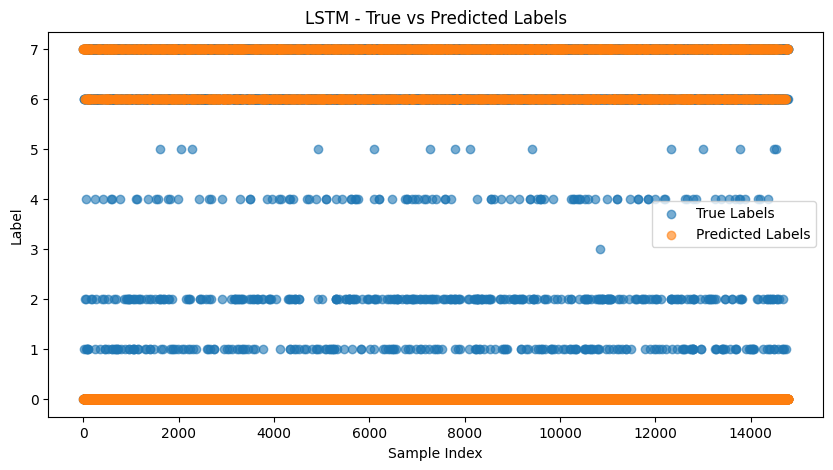

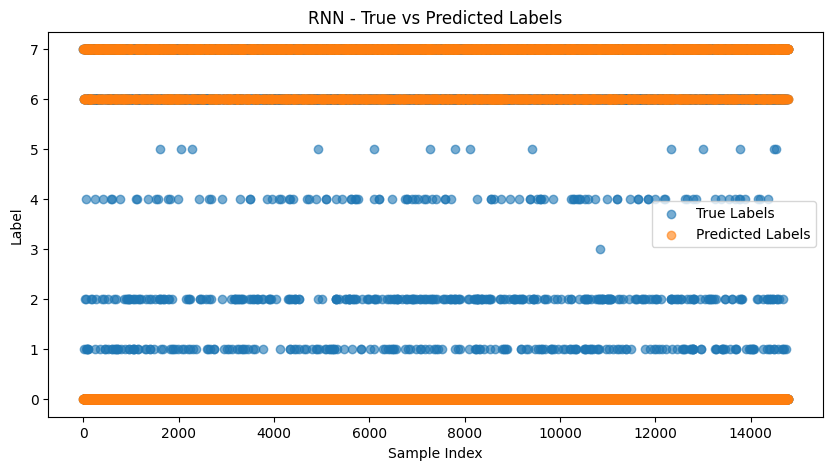

In [ ]:
def plot_real_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_true)), y_true, label='True Labels', alpha=0.6)
    plt.scatter(range(len(y_pred)), y_pred, label='Predicted Labels', alpha=0.6)
    plt.title(f'{model_name} - True vs Predicted Labels')
    plt.xlabel('Sample Index')
    plt.ylabel('Label')
    plt.legend()
    plt.show()

# Llama a la función para cada modelo
plot_real_vs_predicted(y_test, y_pred_cnn, "Attention-Based CNN")
plot_real_vs_predicted(y_test, y_pred_lstm, "LSTM")
plot_real_vs_predicted(y_test, y_pred_rnn, "RNN")


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def permutation_importance_manual(model, X_test, y_test, n_repeats=10):
    """
    Implementación manual de la importancia de características mediante permutaciones.
    """
    baseline_accuracy = accuracy_score(y_test, model.predict(X_test).argmax(axis=1))
    importances = np.zeros(X_test.shape[1])

    for col in range(X_test.shape[1]):
        permuted_accuracies = []
        for _ in range(n_repeats):
            X_test_permuted = X_test.copy()
            np.random.shuffle(X_test_permuted[:, col])
            permuted_accuracy = accuracy_score(y_test, model.predict(X_test_permuted).argmax(axis=1))
            permuted_accuracies.append(permuted_accuracy)
        importances[col] = baseline_accuracy - np.mean(permuted_accuracies)

    return importances

# Calcular importancia de características manualmente
importances = permutation_importance_manual(model, X_test, y_test)

# Graficar resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances, color='teal')
plt.title("Feature Importance (Manual Permutation)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()


462/462 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step
462/462 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step
462/462 ━━━

In [ ]:
!pip install --upgrade eli5 scikit-learn

